In [1]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install -q annoy
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# baixando imagens do kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [3]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm
import itertools
import os
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from pathlib import Path
import glob
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage
from PIL import Image

tqdm.pandas()

In [4]:
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

todas_imagens = os.listdir('/content/images/')
co = 0
contador_por_categoria = 0
os.mkdir('/content/Fashion_data/categories')
for imagem in tqdm(todas_imagens):
    categoria = df[df['id'] == imagem.split('.')[0]]['masterCategory']
    categoria = str(list(categoria)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', categoria)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', categoria))
        contador_por_categoria = 0
    if contador_por_categoria < 500:
        contador_por_categoria += 1
    else:
        continue
    caminho_de = os.path.join('/content/images', imagem)
    caminho_para = os.path.join('/content/Fashion_data/categories', categoria, imagem)
    move(caminho_de, caminho_para)
    co += 1
print(f'Total de imagens movidas: {co}')

100%|██████████| 44441/44441 [03:53<00:00, 190.16it/s]

Total de imagens movidas: 1530


In [5]:
MODELO_URL = 'https://tfhub.dev/google/bit/m-r50x3/1'
TAMANHO_IMAGEM = (224, 224)
TAMANHO_LOTE = 32
N_CLASSES = 256

dataset_dir = '/content/Fashion_data/categories'
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=TAMANHO_IMAGEM, batch_size=TAMANHO_LOTE, interpolation="bilinear")

datagen_validacao = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
generator_validacao = datagen_validacao.flow_from_directory(dataset_dir, subset="validation", shuffle=False, **dataflow_kwargs)

fazer_data_augmentation = False
if fazer_data_augmentation:
  datagen_treino = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  datagen_treino = datagen_validacao

datagen_treino = datagen_treino.flow_from_directory(dataset_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 303 images belonging to 7 classes.
Found 1227 images belonging to 7 classes.


In [6]:
print("Treinando modelo com transfer learning de: ", MODELO_URL)
modelo = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(MODELO_URL)(x),
                           input_shape=TAMANHO_IMAGEM+(3,)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_CLASSES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(datagen_treino.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
modelo.build((None,)+TAMANHO_IMAGEM+(3,))
modelo.summary()


Treinando modelo com transfer learning de:  https://tfhub.dev/google/bit/m-r50x3/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,919 (6.01 MB)

 Trainable params: 1,574,919 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
taxa_perda = 0.003 * TAMANHO_LOTE / 512
COMPRIMENTO = 500
LIMITES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
taxa_perda_cronograma = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=LIMITES,
                                                                   values=[taxa_perda, taxa_perda*0.1, taxa_perda*0.001, taxa_perda*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=taxa_perda_cronograma, momentum=0.9)

taxa_perda_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

modelo.compile(optimizer=optimizer,
              loss=taxa_perda_logits,
              metrics=['accuracy'])

etapas_epoca = datagen_treino.samples // datagen_treino.batch_size
etapas_validacao = generator_validacao.samples // generator_validacao.batch_size
hist = modelo.fit(
    datagen_treino,
    epochs=5, steps_per_epoch=etapas_epoca,
    validation_data=generator_validacao,
    validation_steps=etapas_validacao).history

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2911s 75s/step - accuracy: 0.6590 - loss: 2.0778 - val_accuracy: 0.9549 - val_loss: 0.2896
Epoch 2/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 39:11 64s/step - accuracy: 0.9375 - loss: 0.6031

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 623s 15s/step - accuracy: 0.9375 - loss: 0.6031 - val_accuracy: 0.9549 - val_loss: 0.2856
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2794s 74s/step - accuracy: 0.9581 - loss: 0.3704 - val_accuracy: 0.9722 - val_loss: 0.2087
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 625s 15s/step - accuracy: 0.9375 - loss: 0.5895 - val_accuracy: 0.9653 - val_loss: 0.2320
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2830s 74s/step - accuracy: 0.9631 - loss: 0.3138 - val_accuracy: 0.9653 - val_loss: 0.2323


In [14]:
if not os.path.exists('/content/ImgSim/'):
    os.mkdir('/content/ImgSim/')

extrator_caracteristicas = tf.keras.Model(inputs=modelo.inputs, outputs=modelo.layers[-3].output)
extrator_caracteristicas.save('/content/ImgSim/bit_feature_extractor.h5')

caminho_modelo_salvo = '/content/ImgSim/bit_model'
modelo.save(caminho_modelo_salvo + 'bit_feature_extractor.keras')

In [ ]:
img_caminhos = []
for caminho in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_caminhos.append(caminho)
np.random.shuffle(img_caminhos)

def load_img(caminho):
  img = tf.io.read_file(caminho)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = modelo
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

imgvec_caminho = '/content/img_vectors/'
Path(imgvec_caminho).mkdir(parents=True, exist_ok=True)

for filename in tqdm(img_caminhos[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_caminho, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

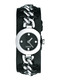

In [24]:
teste_img = '/content/Fashion_data/categories/Accessories/10139.jpg'
dispImage(teste_img)

In [38]:
#hide-output
estilos = pd.read_csv('/content/styles.csv', on_bad_lines='skip',sep=';')
estilos['id'] = estilos['id'].astype('str')
estilos.to_csv('/content/styles.csv', index=False)

In [40]:
def match_id(fname):
  return estilos.index[estilos.id==fname].values[0]

In [44]:
indice_arquivo_para_nome_arquivo = {}
indice_arquivo_para_vetor_arquivo = {}
indice_arquivo_para_produto_id = {}

dimensoes = 7
n_nearest_neighbors = 20
trees = 10000

todos_arquivos = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dimensoes, metric='angular')

for arquivo_indice, arquivo_nome in tqdm(enumerate(todos_arquivos)):
  arquivo_vetor = np.loadtxt(arquivo_nome)
  nome = os.path.basename(arquivo_nome).split('.')[0]
  indice_arquivo_para_nome_arquivo[arquivo_indice] = nome
  indice_arquivo_para_vetor_arquivo[arquivo_indice] = arquivo_vetor
  try:
    indice_arquivo_para_produto_id[arquivo_indice] = match_id(nome)
  except IndexError:
    pass
  t.add_item(arquivo_indice, arquivo_vetor)

t.build(trees)
t.save('t.ann')

caminho = '/content/ImgSim/'
t.save(caminho +'indexer.ann')
pickle.dump(indice_arquivo_para_nome_arquivo, open(caminho +"file_index_to_file_name.p", "wb"))
pickle.dump(indice_arquivo_para_vetor_arquivo, open(caminho +"file_index_to_file_vector.p", "wb"))
pickle.dump(indice_arquivo_para_produto_id, open(caminho +"file_index_to_product_id.p", "wb"))

107it [00:00, 111.80it/s]


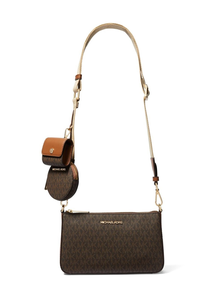

In [57]:
img_url = 'https://static.dafiti.com.br/p/Michael-Kors-Bolsa-Transversal-Jet-Set-Logo-Pequena-35S2gtvc1b200-1587-22636631-1-zoom.jpg'

!wget -q -O img.jpg $img_url
teste_img = 'img.jpg'
topK = 3

teste_vec = np.squeeze(module(load_img(teste_img)))

basewidth = 224
img = Image.open(teste_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

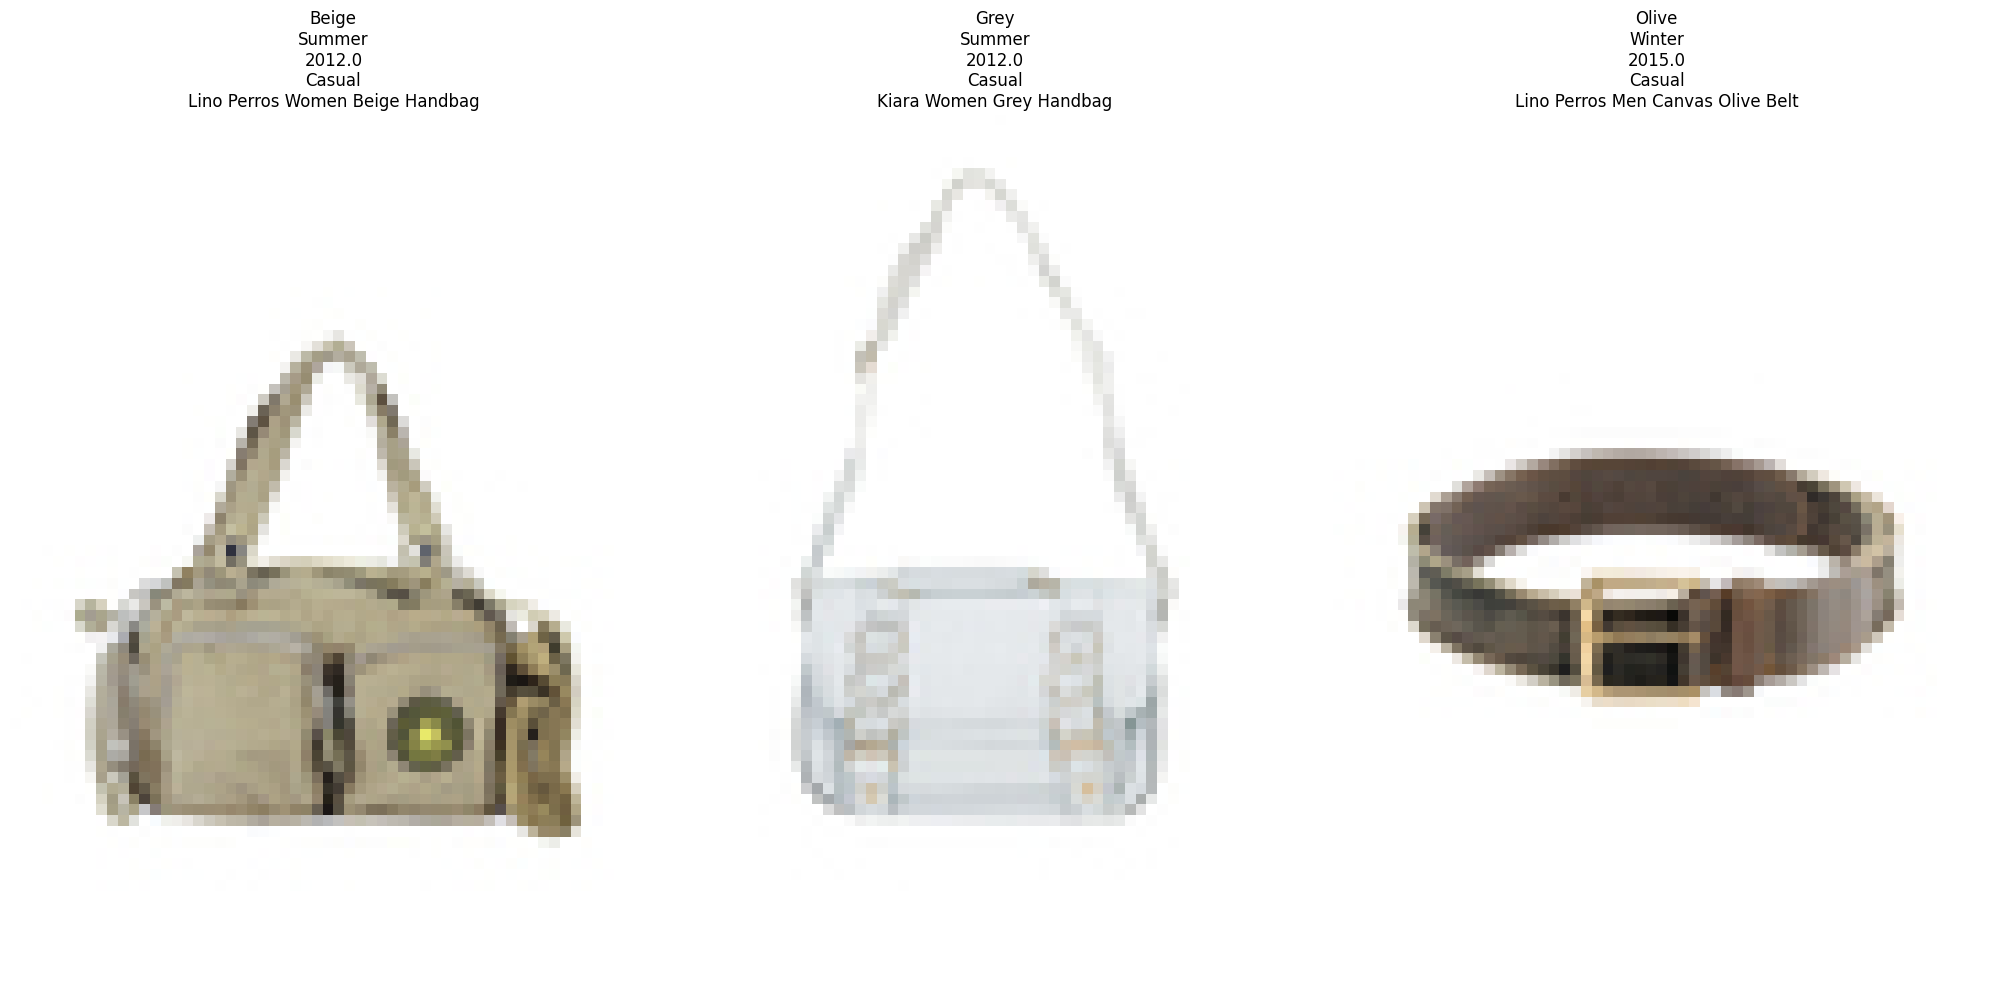

In [61]:
caminho_diretorio = {}
for caminho in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  caminho_diretorio[caminho.name] = caminho

nns = t.get_nns_by_vector(teste_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  image_name = indice_arquivo_para_nome_arquivo[nns[i]]
  image_path = caminho_diretorio[image_name + '.jpg']
  y = indice_arquivo_para_produto_id[nns[i]]
  title = '\n'.join([str(j) for j in list(estilos.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(image_path))
  plt.axis('off')
plt.tight_layout()